In [1]:
import pandas as pd
import numpy as np

read data from preprocessing

In [2]:
x_train = pd.read_csv("train_scale.csv")
x_train.drop(['Unnamed: 0'],axis=1,inplace=True)

x_test = pd.read_csv("test_scale.csv")
x_test.drop(['Unnamed: 0'],axis=1,inplace=True)

y_train = pd.read_csv("train.csv")['TARGET']

In [3]:
print(x_train.shape)
print(y_train.shape)
print(y_train.value_counts())
print(x_test.shape)

(307511, 275)
(307511,)
0    282686
1     24825
Name: TARGET, dtype: int64
(48744, 275)


we found that the class is heavily skewed, we take both desample and oversample

In [4]:
### desample
import random

desample_cnt = 25000
y_train[y_train == [0]]
desample_index = random.sample(y_train[y_train == [0]].index.tolist(), desample_cnt)

negative_index = y_train[y_train == [1]].index.tolist()

desample_y_train = y_train[negative_index + desample_index]
desample_x_train = x_train.iloc[negative_index + desample_index]

In [5]:
desample_y_train.value_counts()

0    25000
1    24825
Name: TARGET, dtype: int64

In [6]:
### oversample
from imblearn.over_sampling import SMOTE
smo = SMOTE(sampling_strategy=1,random_state=42)
X_smo, y_smo = smo.fit_resample(x_train, y_train)

In [7]:
y_smo.value_counts()

1    282686
0    282686
Name: TARGET, dtype: int64

normalization

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(x_train)
x_train = scaler.transform(x_train)
scaler.fit(x_test)
x_test = scaler.transform(x_test)

In [9]:
x_train = pd.DataFrame(x_train)
x_test  = pd.DataFrame(x_test)

logistic regression as baseline

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

lr = LogisticRegression(random_state=0, n_jobs=-1, penalty = 'l2')
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size = 0.25, random_state = 42)

lr.fit(X_train,Y_train)
pred = lr.predict(X_valid)
pred2 = lr.predict(X_train)

print("AUC for test:{}".format(roc_auc_score(pred,Y_valid)))
print("AUC for train:{}".format(roc_auc_score(pred2,Y_train)))
print("-----")
print("accuracy for test:{}".format(accuracy_score(pred,Y_valid)))
print("accuracy for train:{}".format(accuracy_score(pred2,Y_train)))
print("-----")
print("F1 for test:{}".format(f1_score(pred,Y_valid)))
print("F1 for train:{}".format(f1_score(pred2,Y_train)))
print("-----")

AUC for test:0.7053101374740215
AUC for train:0.7216436322279355
-----
accuracy for test:0.9194307864408543
accuracy for train:0.9192916885267937
-----
F1 for test:0.02395209580838323
F1 for train:0.023604699958036095
-----


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

lr = LogisticRegression(random_state=0, n_jobs=-1, penalty = 'l2')
X_train, X_valid, Y_train, Y_valid = train_test_split(desample_x_train, desample_y_train, test_size = 0.25, random_state = 42)

lr.fit(X_train,Y_train)
pred = lr.predict(X_valid)
pred2 = lr.predict(X_train)

print("AUC for test:{}".format(roc_auc_score(pred,Y_valid)))
print("AUC for train:{}".format(roc_auc_score(pred2,Y_train)))
print("-----")
print("accuracy for test:{}".format(accuracy_score(pred,Y_valid)))
print("accuracy for train:{}".format(accuracy_score(pred2,Y_train)))
print("-----")
print("F1 for test:{}".format(f1_score(pred,Y_valid)))
print("F1 for train:{}".format(f1_score(pred2,Y_train)))
print("-----")

AUC for test:0.6851585676384504
AUC for train:0.6842624735636281
-----
accuracy for test:0.6851569398731637
accuracy for train:0.6842485549132948
-----
F1 for test:0.6826347305389222
F1 for train:0.6814438834741758
-----


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

lr = LogisticRegression(random_state=0, n_jobs=-1, penalty = 'l2')
X_train, X_valid, Y_train, Y_valid = train_test_split(X_smo, y_smo, test_size = 0.25, random_state = 42)

lr.fit(X_train,Y_train)
pred = lr.predict(X_valid)
pred2 = lr.predict(X_train)

print("AUC for test:{}".format(roc_auc_score(pred,Y_valid)))
print("AUC for train:{}".format(roc_auc_score(pred2,Y_train)))
print("-----")
print("accuracy for test:{}".format(accuracy_score(pred,Y_valid)))
print("accuracy for train:{}".format(accuracy_score(pred2,Y_train)))
print("-----")
print("F1 for test:{}".format(f1_score(pred,Y_valid)))
print("F1 for train:{}".format(f1_score(pred2,Y_train)))
print("-----")

AUC for test:0.708298608381162
AUC for train:0.7104024900875925
-----
accuracy for test:0.7081284534784178
accuracy for train:0.710243874829316
-----
F1 for test:0.7121987972820248
F1 for train:0.7141816963693758
-----


GBDT

K-fold is used for hyperparameters selection

In [117]:
# sklearn version
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.model_selection import KFold


n_estimators = [15,25,50]
learning_rate = [ 0.05, 0.1, 0.2, 0.5]

kf = KFold(n_splits=5,shuffle=True)

group_cnt = len(n_estimators) * len(learning_rate) 
results = []
index = 0
for n in n_estimators:
    for lr in learning_rate:
        index += 1
        gbm = GradientBoostingClassifier(n_estimators=n, learning_rate = lr, random_state=42, max_depth=5)
        AUC = []
        for train_index, test_index in kf.split(desample_x_train):     ### 获得 train 的 index    ### 获得 test  的 index
            X_train, X_valid = desample_x_train.iloc[train_index], desample_x_train.iloc[test_index]
            Y_train, Y_valid = desample_y_train.iloc[train_index], desample_y_train.iloc[test_index]
            gbm.fit(X_train,Y_train)
    
            AUC.append(roc_auc_score(gbm.predict(X_valid),Y_valid))
        
        print("Experiments {}: n_estimator = {}, lr = {}, mean AUC for kfold = {}, all AUCs are:\n".format(index,n, lr, sum(AUC) / len(AUC)), end="  ")
        print(AUC)

Experiments 1: n_estimator = 10, lr = 0.01, mean AUC for kfold = 0.656650809802559, all AUCs are:
  [0.6628165493523377, 0.6509760736753093, 0.6594849922527997, 0.6523161657405729, 0.657660267991775]
Experiments 2: n_estimator = 10, lr = 0.05, mean AUC for kfold = 0.6599237731157599, all AUCs are:
  [0.6621228884777692, 0.659179851091184, 0.6532554658332459, 0.6623362703374074, 0.662724389839193]
Experiments 3: n_estimator = 10, lr = 0.1, mean AUC for kfold = 0.6657619712509179, all AUCs are:
  [0.6728343302441296, 0.6652958989121088, 0.6708674170637635, 0.6559672437613224, 0.6638449662732647]
Experiments 4: n_estimator = 25, lr = 0.01, mean AUC for kfold = 0.6578701540072116, all AUCs are:
  [0.663426333199776, 0.6493989185124358, 0.6588661624659075, 0.6569903440327567, 0.6606690118251819]
Experiments 5: n_estimator = 25, lr = 0.05, mean AUC for kfold = 0.6691756412938114, all AUCs are:
  [0.6713330143798362, 0.6696847391396371, 0.6661615588767488, 0.6733086664010302, 0.66539022767180

From the above we can learn that     
n_estimator : 100 > 50 > 25 > 10  ； lr: 0.1 > 0.05 > 0.01

In [118]:
# sklearn version
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.model_selection import KFold


n_estimators = [100, 125, 150]
learning_rate = [ 0.1, 0.2, 0.5]

kf = KFold(n_splits=5,shuffle=True)

group_cnt = len(n_estimators) * len(learning_rate) 
results = []
index = 0
for n in n_estimators:
    for lr in learning_rate:
        index += 1
        gbm = GradientBoostingClassifier(n_estimators=n, learning_rate = lr, random_state=42, max_depth=5)
        AUC = []
        for train_index, test_index in kf.split(desample_x_train):     ### 获得 train 的 index    ### 获得 test  的 index
            X_train, X_valid = desample_x_train.iloc[train_index], desample_x_train.iloc[test_index]
            Y_train, Y_valid = desample_y_train.iloc[train_index], desample_y_train.iloc[test_index]
            gbm.fit(X_train,Y_train)
    
            AUC.append(roc_auc_score(gbm.predict(X_valid),Y_valid))

Experiments 1: n_estimator = 100, lr = 0.1, mean AUC for kfold = 0.6899266388205039, all AUCs are:
  [0.6883032494232421, 0.6915643572335154, 0.6912852993427447, 0.6895777266868184, 0.6889025614161988]
Experiments 2: n_estimator = 100, lr = 0.2, mean AUC for kfold = 0.6856045973162752, all AUCs are:
  [0.6873897647552081, 0.6821767315107506, 0.6863681256645642, 0.6823245393200594, 0.6897638253307942]
Experiments 3: n_estimator = 100, lr = 0.5, mean AUC for kfold = 0.6706089869574089, all AUCs are:
  [0.6608148685711965, 0.6719504711605833, 0.6773656761386447, 0.6704461778911031, 0.672467741025517]
Experiments 4: n_estimator = 125, lr = 0.1, mean AUC for kfold = 0.6902442082918798, all AUCs are:
  [0.6941392578926681, 0.6820064964149402, 0.6877022460080249, 0.6976600314021725, 0.6897130097415939]
Experiments 5: n_estimator = 125, lr = 0.2, mean AUC for kfold = 0.6875068675370389, all AUCs are:
  [0.6903293088883414, 0.6800997034493321, 0.6884387068051666, 0.686036037088477, 0.6926305814

In [119]:
# sklearn version
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.model_selection import KFold


n_estimators = [100, 125, 150, 175,200, 225, 250]
learning_rate = [ 0.1, 0.15]

kf = KFold(n_splits=5,shuffle=True)

group_cnt = len(n_estimators) * len(learning_rate) 
results = []
index = 0
for n in n_estimators:
    for lr in learning_rate:
        index += 1
        gbm = GradientBoostingClassifier(n_estimators=n, learning_rate = lr, random_state=42, max_depth=5)
        AUC = []
        for train_index, test_index in kf.split(desample_x_train):     ### 获得 train 的 index    ### 获得 test  的 index
            X_train, X_valid = desample_x_train.iloc[train_index], desample_x_train.iloc[test_index]
            Y_train, Y_valid = desample_y_train.iloc[train_index], desample_y_train.iloc[test_index]
            gbm.fit(X_train,Y_train)
    
            AUC.append(roc_auc_score(gbm.predict(X_valid),Y_valid))
        
        print("Experiments {}: n_estimator = {}, lr = {}, mean AUC for kfold = {}, all AUCs are:\n".format(index,n, lr, sum(AUC) / len(AUC)), end="  ")
        print(AUC)

Experiments 1: n_estimator = 100, lr = 0.1, mean AUC for kfold = 0.6903831771509621, all AUCs are:
  [0.6898373880215225, 0.6890156741700985, 0.6823933201795314, 0.7000498765292058, 0.6906196268544527]
Experiments 2: n_estimator = 100, lr = 0.15, mean AUC for kfold = 0.6897723596129024, all AUCs are:
  [0.6919766700927956, 0.6873844359669512, 0.6849672426667629, 0.6976230835226116, 0.6869103658153906]
Experiments 3: n_estimator = 125, lr = 0.1, mean AUC for kfold = 0.6874916010961658, all AUCs are:
  [0.6909980694971362, 0.6878880259755474, 0.6881691355330248, 0.6798934867874352, 0.6905092876876854]
Experiments 4: n_estimator = 125, lr = 0.15, mean AUC for kfold = 0.6884227824827844, all AUCs are:
  [0.6872919305996066, 0.6862654089857226, 0.6887569597453839, 0.6860724385841579, 0.6937271744990514]
Experiments 5: n_estimator = 150, lr = 0.1, mean AUC for kfold = 0.6891550538361396, all AUCs are:
  [0.6895976116849247, 0.6850358961363584, 0.6932158087122806, 0.6847991063300041, 0.693126

finally we confirm the hyperparaters:       
n_estimator = 100, lr = 0.1

after determining hyperparameter, we apply it to different sampled dataset

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

gbm = GradientBoostingClassifier(n_estimators=100, learning_rate = 0.1, random_state=42, max_depth=5)
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size = 0.25, random_state = 42)

gbm.fit(X_train,Y_train)
pred = gbm.predict(X_valid)
pred2 = gbm.predict(X_train)

print("AUC for test:{}".format(roc_auc_score(pred,Y_valid)))
print("AUC for train:{}".format(roc_auc_score(pred2,Y_train)))
print("-----")
print("accuracy for test:{}".format(accuracy_score(pred,Y_valid)))
print("accuracy for train:{}".format(accuracy_score(pred2,Y_train)))
print("-----")
print("F1 for test:{}".format(f1_score(pred,Y_valid)))
print("F1 for train:{}".format(f1_score(pred2,Y_train)))
print("-----")

AUC for test:0.723511042958193
AUC for train:0.8823032018715535
-----
accuracy for test:0.9196389084003226
accuracy for train:0.9216417425086609
-----
F1 for test:0.040683229813664595
F1 for train:0.07103937493574586
-----


In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

gbm = GradientBoostingClassifier(n_estimators=100, learning_rate = 0.1, random_state=42, max_depth=5)
X_train, X_valid, Y_train, Y_valid = train_test_split(desample_x_train, desample_y_train, test_size = 0.25, random_state = 42)

gbm.fit(X_train,Y_train)
pred = gbm.predict(X_valid)
pred2 = gbm.predict(X_train)

print("AUC for test:{}".format(roc_auc_score(pred,Y_valid)))
print("AUC for train:{}".format(roc_auc_score(pred2,Y_train)))
print("-----")
print("accuracy for test:{}".format(accuracy_score(pred,Y_valid)))
print("accuracy for train:{}".format(accuracy_score(pred2,Y_train)))
print("-----")
print("F1 for test:{}".format(f1_score(pred,Y_valid)))
print("F1 for train:{}".format(f1_score(pred2,Y_train)))
print("-----")

AUC for test:0.6921661737575615
AUC for train:0.7316151976676741
-----
accuracy for test:0.6921409649193224
accuracy for train:0.7316152858060373
-----
F1 for test:0.6926344473831851
F1 for train:0.7311620426216324
-----


In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

gbm = GradientBoostingClassifier(n_estimators=100, learning_rate = 0.1, random_state=42, max_depth=5)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_smo, y_smo, test_size = 0.25, random_state = 42)

gbm.fit(X_train,Y_train)
pred = gbm.predict(X_valid)
pred2 = gbm.predict(X_train)

print("AUC for test:{}".format(roc_auc_score(pred,Y_valid)))
print("AUC for train:{}".format(roc_auc_score(pred2,Y_train)))
print("-----")
print("accuracy for test:{}".format(accuracy_score(pred,Y_valid)))
print("accuracy for train:{}".format(accuracy_score(pred2,Y_train)))
print("-----")
print("F1 for test:{}".format(f1_score(pred,Y_valid)))
print("F1 for train:{}".format(f1_score(pred2,Y_train)))
print("-----")

AUC for test:0.956194270802831
AUC for train:0.9563357907505107
-----
accuracy for test:0.9524631570010542
accuracy for train:0.952614090074028
-----
F1 for test:0.9502063926128489
F1 for train:0.9503750336505332
-----


Random Forest

hyperparameters

In [121]:
from sklearn.ensemble import RandomForestClassifier


n_estimators = [100, 125, 150, 175,200]
criterion = {"gini","entropy"}
kf = KFold(n_splits=5,shuffle=True)

group_cnt = len(n_estimators) * len(criterion) 
results = []
index = 0
for n in n_estimators:
    for c in criterion:
        index += 1
        rfc = RandomForestClassifier(n_estimators=n, criterion = c, random_state=42, n_jobs=-1)
        AUC = []
        for train_index, test_index in kf.split(desample_x_train):     ### 获得 train 的 index    ### 获得 test  的 index
            X_train, X_valid = desample_x_train.iloc[train_index], desample_x_train.iloc[test_index]
            Y_train, Y_valid = desample_y_train.iloc[train_index], desample_y_train.iloc[test_index]
            gbm.fit(X_train,Y_train)
    
            AUC.append(roc_auc_score(gbm.predict(X_valid),Y_valid))
        
        print("Experiments {}: n_estimator = {}, criterion = {}, mean AUC for kfold = {}, all AUCs are:\n".format(index,n, c, sum(AUC) / len(AUC)), end="  ")
        print(AUC)

Experiments 1: n_estimator = 100, criterion = gini, mean AUC for kfold = 0.688294676154255, all AUCs are:
  [0.6878509546563139, 0.6873880547874367, 0.6920201004231529, 0.6856053199582706, 0.6886089509461006]
Experiments 2: n_estimator = 100, criterion = entropy, mean AUC for kfold = 0.6909257060819682, all AUCs are:
  [0.6951235649546827, 0.6863428809319927, 0.690625656786026, 0.6880105263098502, 0.6945259014272891]
Experiments 3: n_estimator = 125, criterion = gini, mean AUC for kfold = 0.6882427826141599, all AUCs are:
  [0.6851728164339529, 0.6798688112039554, 0.6919211449609873, 0.6956134596067192, 0.6886376808651848]
Experiments 4: n_estimator = 125, criterion = entropy, mean AUC for kfold = 0.6871917363587712, all AUCs are:
  [0.687092411130871, 0.6864973862594805, 0.6858028591668407, 0.6871940518588526, 0.6893719733778111]
Experiments 5: n_estimator = 150, criterion = gini, mean AUC for kfold = 0.6857633294214991, all AUCs are:
  [0.6856925478348439, 0.6855082245988443, 0.68409

n_estimator= 50, max_depth=10, criterion = "entropy"

In [44]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

rfc = RandomForestClassifier(n_estimators=50, criterion = "entropy", max_depth=10, max_features=20,random_state=42, n_jobs=-1)
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size = 0.25, random_state = 42)

rfc.fit(X_train,Y_train)
pred = rfc.predict(X_valid)
pred2 = rfc.predict(X_train)

print("AUC for test:{}".format(roc_auc_score(pred,Y_valid)))
print("AUC for train:{}".format(roc_auc_score(pred2,Y_train)))
print("-----")
print("accuracy for test:{}".format(accuracy_score(pred,Y_valid)))
print("accuracy for train:{}".format(accuracy_score(pred2,Y_train)))
print("-----")
print("F1 for test:{}".format(f1_score(pred,Y_valid)))
print("F1 for train:{}".format(f1_score(pred2,Y_train)))
print("-----")

AUC for test:0.9597468650814298
AUC for train:0.9596861976399772
-----
accuracy for test:0.9194958245531881
accuracy for train:0.9193870781718141
-----
F1 for test:0.0006458905215565962
F1 for train:0.004497751124437781
-----


In [42]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

rfc = RandomForestClassifier(n_estimators=50, criterion = "entropy", random_state=42, max_depth = 10,max_features=20,n_jobs=-1)
X_train, X_valid, Y_train, Y_valid = train_test_split(desample_x_train, desample_y_train, test_size = 0.25, random_state = 42)

rfc.fit(X_train,Y_train)
pred = rfc.predict(X_valid)
pred2 = rfc.predict(X_train)

print("AUC for test:{}".format(roc_auc_score(pred,Y_valid)))
print("AUC for train:{}".format(roc_auc_score(pred2,Y_train)))
print("-----")
print("accuracy for test:{}".format(accuracy_score(pred,Y_valid)))
print("accuracy for train:{}".format(accuracy_score(pred2,Y_train)))
print("-----")
print("F1 for test:{}".format(f1_score(pred,Y_valid)))
print("F1 for train:{}".format(f1_score(pred2,Y_train)))
print("-----")

AUC for test:0.6788213256430664
AUC for train:0.7356646248496366
-----
accuracy for test:0.6788151240266517
accuracy for train:0.7356561764076215
-----
F1 for test:0.6785570820277979
F1 for train:0.7356703237891355
-----


In [78]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

rfc = RandomForestClassifier(n_estimators=50, criterion = "entropy", random_state=42,n_jobs=-1)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_smo, y_smo, test_size = 0.25, random_state = 42)

rfc.fit(X_train,Y_train)
pred = rfc.predict(X_valid)
pred2 = rfc.predict(X_train)

print("AUC for test:{}".format(roc_auc_score(pred,Y_valid)))
print("AUC for train:{}".format(roc_auc_score(pred2,Y_train)))
print("-----")
print("accuracy for test:{}".format(accuracy_score(pred,Y_valid)))
print("accuracy for train:{}".format(accuracy_score(pred2,Y_train)))
print("-----")
print("F1 for test:{}".format(f1_score(pred,Y_valid)))
print("F1 for train:{}".format(f1_score(pred2,Y_train)))
print("-----")

AUC for test:0.9538392342836036
AUC for train:0.9999528357505012
-----
accuracy for test:0.9512604090757943
accuracy for train:0.9999528334146957
-----
F1 for test:0.9493459606914655
F1 for train:0.9999528333034612
-----


results visulization for comparison

In [107]:
results = pd.DataFrame([],columns=["model","data","f1-score","AUC-score"])
results["model"] = ["logistic Regression"] * 3 + ["GBDT"] * 3 + ["Random Forest"] * 3
results["data"] = (["Original","desample","overSample"]  ) * 3
results["f1-score"] = [0.0339,0.6826,0.7121,   0.0506, 0.6926, 0.8502,    0.0125, 0.6785, 0.8493]
results['AUC-score'] = [0.6053, 0.6851, 0.7082,  0.6235, 0.6921, 0.8561,   0.8597, 0.6788,  0.8538]

In [108]:
results

,model,data,f1-score,AUC-score
0,logistic Regression,Original,0.0339,0.6053
1,logistic Regression,desample,0.6826,0.6851
2,logistic Regression,overSample,0.7121,0.7082
3,GBDT,Original,0.0506,0.6235
4,GBDT,desample,0.6926,0.6921
5,GBDT,overSample,0.8502,0.8561
6,Random Forest,Original,0.0125,0.8597
7,Random Forest,desample,0.6785,0.6788
8,Random Forest,overSample,0.8493,0.8538


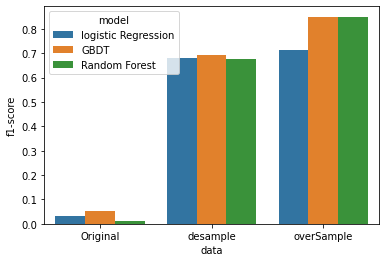

In [109]:
import seaborn as sns

sns.barplot(x="data", y="f1-score",hue="model",data=results)

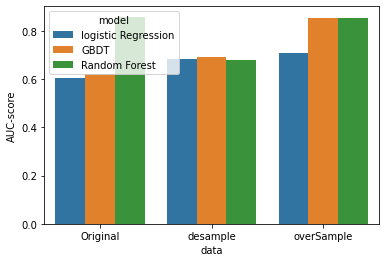

In [110]:
sns.barplot(x="data", y="AUC-score",hue="model",data=results)

output prediction for test data

In [98]:
rfc_submit = pd.read_csv("test.csv")[['SK_ID_CURR']]
rfc_pred = rfc.predict_proba(x_test)[:, 1]
rfc_submit['TARGET'] = rfc_pred
rfc_submit.to_csv("submission.csv",index=0)
rfc_submit.head()

D:\Anaconda3\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


,SK_ID_CURR,TARGET
0,100001,0.06
1,100005,0.34
2,100013,0.10
3,100028,0.32
4,100038,0.90
